# Doctoplant - Discover diseases on leaves photos.

### CNN model with TensorFlow using GPU

## 1. Environment preparation
1. Make sure TensorFlow is installed 
2. Check if Drive is connected
3. Unzip dataset
4. Check if we are connected to GPU

It's faster to copy the Dataset from our own Drive to Collab environment. And from there, unzip the Dataset and start working on it.

It takes overall less than 5 minutes to copy and unzip the whole Dataset, so it worth it to follow this process.

In [ ]:
# Import TensorFlow into collab
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


In [ ]:
# Unzip Background images (to execute only ONCE)
!unzip -u '/content/sample_data/mask_img.zip' -d '/content/sample_data'
# Unzip Dataset (to execute only ONCE)
!unzip -u "/content/sample_data/plantvillage_dataset_augmented_fixed.zip" -d "/content/sample_data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im41336.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im41336.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im40996.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im40996.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im41450.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im41450.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im43247.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im43247.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im42159.jpg  
  inf

In [ ]:
!unzip -u '/content/sample_data/dataset_test_final.zip' -d '/content/sample_data/'

Archive:  /content/sample_data/dataset_test_final.zip
   creating: /content/sample_data/dataset_Test_V2/
   creating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/08fbc31575.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/76382d279e.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/7cf3975b4e.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/fb6f13d07c.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/f6211324b3.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/49e63497ff.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/36a69240c4.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/39bc4e93ba.jpg  
  inflating: /content/sample_data/dataset_Test_V2/Strawberry___healthy/fa0bd65467.jpg  
  inflating: /content/sample_da

### Use of GPU

For the purpose of Image Classification, we will use Google GPU to allow us to use Google resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 2. Code - preparation and training CNN

As we have already performed the DataViz and Data Exploration, we can directly work on our CNN model.
We need:
1. Import the required libraries
2. Create a DataFrame with all information
3. Prepare Data (train/validation)
4. Create Datasets
5. Create CNN model
6. Train our model


### 1. Import the required libraries

In [ ]:
# Import required packages
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from PIL import Image
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Create DataFrame 

We will create DataFrame to store required information for our script.

Dataframe composed of:
- List of Plants name (plant)
- List of Plants Categories (category)
- List of images path (img_path) > Features
- List of Plants name + Plants Categories (plant___category) > Labels
- Background of the leaves plant. For other Category no background is required (back_path)

In [ ]:
# Get Path to Image folders
IMG_PATH = '/content/sample_data/plantvillage_dataset_augmented'
BCK_PATH = '/content/sample_data/mask_img'
TEST_PATH='/content/sample_data/dataset_Test_V2'

# Image size
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
OUTPUT_SHAPE = 39
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
# Create Dataframe
def create_info_df(dir_path, test=False):
  """
  From the Image directory, create a DataFrame with 5 columns :
    - List of Plants name (plant)
    - List of Plants Categories (category)
    - List of images path (img_path) > Features
    - List of Plants name + Plants Categories (plant___category) > Labels
    - Background of the leaves plant. For other Category no background is required (back_path)

  Return created DataFrame
  """
  list_plants = []
  img_listdir = glob.glob(os.path.join(dir_path, '*')) # list of directories
  # Loop through each Plants directories
  for img_dir in img_listdir:
    plant = img_dir.split('/')[-1]

    for img in os.listdir(img_dir): # For each image in the Plant directory
      list_plants.append([*plant.split('___'), os.path.join(img_dir,img), plant])

  # Create DataFrame from the list
  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])
  # Add Background for each plant. If Category "Others", add word "Others" instead of background path
  if test:
    df['back_path'] = 'Others'
  else:
    df['back_path'] = df['plant'].apply(lambda x: x if x == 'Others' else os.path.join(BCK_PATH, x) +'.jpg')
  

  return df

# Get DF
df_info = create_info_df(IMG_PATH)
test_info = create_info_df(TEST_PATH, True)

#Unique label list:
unique_plant_cat = np.unique(df_info['plant___category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class = unique_plant_cat.tolist()


df_info['label_int'] = df_info['plant___category'].apply(lambda x: list_class.index(x))
test_info['label_int'] = test_info['plant___category'].apply(lambda x: list_class.index(x))

Number of Categories to predict:  39


In [ ]:
df_info.head()

,plant,category,img_path,plant___category,back_path,label_int
0,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/plantvillage_dataset_augm...,Orange___Haunglongbing_(Citrus_greening),/content/sample_data/mask_img/Orange.jpg,15
1,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/plantvillage_dataset_augm...,Orange___Haunglongbing_(Citrus_greening),/content/sample_data/mask_img/Orange.jpg,15
2,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/plantvillage_dataset_augm...,Orange___Haunglongbing_(Citrus_greening),/content/sample_data/mask_img/Orange.jpg,15
3,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/plantvillage_dataset_augm...,Orange___Haunglongbing_(Citrus_greening),/content/sample_data/mask_img/Orange.jpg,15
4,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/plantvillage_dataset_augm...,Orange___Haunglongbing_(Citrus_greening),/content/sample_data/mask_img/Orange.jpg,15


In [ ]:
test_info.head()

,plant,category,img_path,plant___category,back_path,label_int
0,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/dataset_Test_V2/Orange___...,Orange___Haunglongbing_(Citrus_greening),Others,15
1,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/dataset_Test_V2/Orange___...,Orange___Haunglongbing_(Citrus_greening),Others,15
2,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/dataset_Test_V2/Orange___...,Orange___Haunglongbing_(Citrus_greening),Others,15
3,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/dataset_Test_V2/Orange___...,Orange___Haunglongbing_(Citrus_greening),Others,15
4,Orange,Haunglongbing_(Citrus_greening),/content/sample_data/dataset_Test_V2/Orange___...,Orange___Haunglongbing_(Citrus_greening),Others,15


### 3. Prepare Data

We will create multiple functions to help us proceed with the remaining steps.
- Split Data into Validation / Train DataFrame
- Create Datasets (including Labels and Image decoding)
- Save model
- Train model

In [ ]:
# Functions
LIST_CLASS_LEN = len(list_class)

# Split DataFrame into 2 DataFrame - Validation and Training DataFrame
def split_data(df):
  """
    Get Dataframe and split it in Train and Validation DataFrame.
    Train: 80% of full data
    Validation: 20% of Data
  """
  df = df.sample(frac=1, random_state=42).reset_index()
  split_size = round(len(df)*80/100)
  train = df.iloc[:split_size]
  valid = df.iloc[split_size:]

  return train, valid

# Decode Image
def decode_img(path, label, back, image_shape=IMG_SHAPE):
  """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    return: resized tensor image and label
  """
  # Threshold for background
  threshold = 10

  # Read the image file
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)

  # Resize image to our desired size
  img = tf.image.resize(img, image_shape[:2])

  # Transform label integer to one hot vector
  label_one_hot=tf.one_hot(label,depth=LIST_CLASS_LEN)

  # If Image is from Others category, we don't need to add a Background
  if back == 'Others':
    return tf.cast(img, tf.float32)/255, label_one_hot

  # Else, we get the Background path, and add it to the leaf image
  bkg = tf.io.read_file(back)
  bkg = tf.image.decode_jpeg(bkg, channels=3)

  # Resize image to our desired size
  bkg = tf.image.resize(bkg, image_shape[:2])

  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(n_img, tf.float32)/255, label_one_hot



# Create Datasets for Model
def create_dataset(datapoint, valid_data=False):
  X, y, back = datapoint['img_path'], datapoint['label_int'], datapoint['back_path']

  # For Validation set - We do not shuffle
  if valid_data:
    print('Creation of the validation dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  # For Training set
  else:
    print('Creation of the Training dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

# Save and load model
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in ad models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/DataScientest/30 - Models/saved_models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M"))
  model_path = modeldir + "-" + suffix + ".h5" #save format of model
  print(f"Save model to: {model_path}...")
  model.save(model_path)
  return model_path


# Create a function to load a model
def load_model(model_path):
  """
  Load a saved model from a specify path
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path)
  return model


def display_imgs(display_list, label=None):
  """
  Display 3 Images:
   - Segmented Image
   - Background Image
   - Image with Background
  """
  plt.figure(figsize=(16,16))
  # Title of each images
  labels = ['Image '+label, 'Background', ' Image with Background']

  for i, data in enumerate(display_list):
    plt.subplot(1,len(display_list)+1, i+1)
    plt.imshow(np.squeeze(data).astype('uint8'))
    # Below commented line is working the same way as above
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(data))
    plt.title(labels[i])
    plt.axis('off')
  # Show images
  plt.show()
  

The Dataset is a leaf image with Black background.
To help the model recognize a leaf from a photo taken in a natural environment, we will add a backgound (of a plants) in each images.

This process will be done "*on the fly*" to avoid creating a new dataset.

The process is as follow:
- Take the leaf image with black background and convert it to an array.
> When the image is converted to an array, a black pixel is represented by 0.
- For every pixel (converted to a number) below a chosen threshold, replace the pixel with the pixel from the backgound image.
> we use `tf.where(pixel_img < threshold, pixel_backgrnd, pixel_img)`. We can translate it as: 
> - if **pixel_image** is below **threshold**, use **pixel_backgrnd**
> - else, use **pixel_img**

Let's see an example!

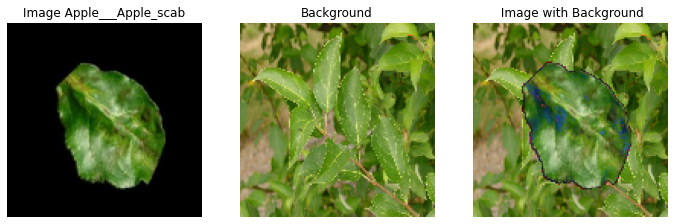

In [ ]:
# Let's see an example:
# Get a random number
random = np.random.randint(0, len(df_info))

def get_img_bck(img_path, bckgrnd_path):
  """
  """
  # Threshold for background
  threshold = 10
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize image to our desired size
  img = tf.image.resize(img, IMG_SHAPE[:2])

  bkg = tf.io.read_file(bckgrnd_path)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  # Resize image to our desired size
  bkg = tf.image.resize(bkg, IMG_SHAPE[:2])
  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return img, bkg, n_img

imgs_list = list(get_img_bck(df_info.iloc[random]['img_path'], df_info.iloc[random]['back_path']))

display_imgs(imgs_list, df_info.iloc[random]['plant___category'])

Split Data to Validation set and Train set.

In [ ]:
train, valid = split_data(df_info)
print("Train df shape: ", train.shape)
print("Valid df shape: ", valid.shape)

Train df shape:  (91262, 7)
Valid df shape:  (22815, 7)


In [ ]:
train['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              4369
Tomato___Tomato_Yellow_Leaf_Curl_Virus                4329
Soybean___healthy                                     4090
Others___Others                                       3999
Tomato___Late_blight                                  3093
Squash___Powdery_mildew                               2916
Tomato___Septoria_leaf_spot                           2817
Tomato___Spider_mites Two-spotted_spider_mite         2676
Apple___healthy                                       2649
Tomato___healthy                                      2526
Potato___Late_blight                                  2414
Pepper,_bell___Bacterial_spot                         2397
Blueberry___healthy                                   2394
Potato___Early_blight                                 2380
Tomato___Early_blight                                 2370
Corn_(maize)___Northern_Leaf_Blight                   2346
Pepper,_bell___healthy                                23

In [ ]:
valid['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              1138
Tomato___Tomato_Yellow_Leaf_Curl_Virus                1028
Others___Others                                       1001
Soybean___healthy                                     1000
Squash___Powdery_mildew                                754
Tomato___Septoria_leaf_spot                            725
Tomato___Late_blight                                   725
Tomato___Spider_mites Two-spotted_spider_mite          676
Tomato___healthy                                       656
Apple___healthy                                        641
Tomato___Early_blight                                  630
Potato___Early_blight                                  620
Pepper,_bell___healthy                                 617
Blueberry___healthy                                    610
Corn_(maize)___Northern_Leaf_Blight                    609
Pepper,_bell___Bacterial_spot                          594
Potato___Late_blight                                   5

We have a distribution 80/20 for each plant category. And all category are present in each DataFrame.

### 4. Create Datasets

In [ ]:
dataset_train = create_dataset(train)
dataset_valid = create_dataset(valid, valid_data=True)

Creation of the Training dataset...
Creation of the validation dataset...


Now that we have created our Train and Validation Dataset, let's visualise one batch or the Train Dataset to make sure it has the expected shape.

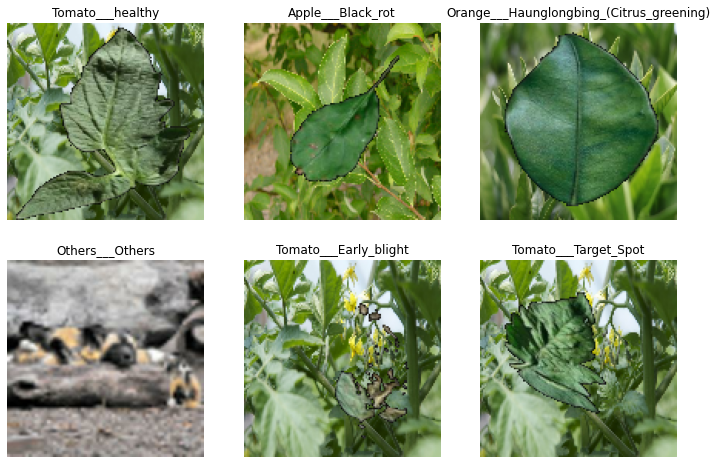

In [ ]:
# Check if records are well created in datasets
img_batch, label_batch = next(iter(dataset_train))

plt.figure(figsize=(12, 8))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow((img_batch[i].numpy()*255).astype("uint8"))
  label = label_batch[i]
  # Get the Label name from the Boolean list
  plt.title(unique_plant_cat[label])
  plt.axis("off")

We can see that our Batch is composed by:
- `img_batch` which represents our modified images with the background.
- `label_batch` which represent our labels.

We chose to only show 6 entries but each batch is composed of 32 images/labels pairs.

### 5. Create CNN model

We are creating our own CNN model composed by:
- 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
- 1 Flatten layer
- 2 Dense layers ReLU activation (and Dropout)
- 1 Final Dense layer with Softmax activation
> Return 39 probabilities, for each Classes we want to predict.


We specify the training configuration:
- We use `Adam optimizer` with Learning Rate of 0.0005. The choice of this learning rate have been made after multiple iteration. It allow the model to converge more quicker.
- We use `Categorical Crossentropy` loss function.  
- We will monitor our model with the `Accuracy` metric.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D

regularizer = tf.keras.regularizers.l2(5e-3)
INPUT_SHAPE = IMG_SHAPE

# Create model
# 4 conv2D layers
# Batch Normalisation and MaxPooling
def get_model():
  """
  Create a 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
  And 2 Dense layers ReLU activation (and Dropout)
  
  Return 39 probabilities (= number of plants + other category we want to predict) - activation Softmax
  """

  model = Sequential([
    # First CNN                     
    Conv2D(128, kernel_size=3, input_shape=INPUT_SHAPE, activation='relu', kernel_regularizer=regularizer),
    # Second CNN
    Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer=regularizer),
    BatchNormalization(),
    MaxPooling2D(),
    # Third CNN
    Conv2D(512, kernel_size=3, activation='relu', kernel_regularizer=regularizer), 
    BatchNormalization(),
    MaxPooling2D(),
    # Flatten last CNN output for Dense layers
    #Flatten(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizer),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizer),
    Dropout(0.2),
    # Return 39 probabilities (= number of plants we want to predict)
    Dense(OUTPUT_SHAPE, activation= 'softmax')
  ])

  return model

model = get_model()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show Summary 
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 256)     295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 256)     1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 512)       1180160   
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 60, 512)       2048      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 512)      

We will create two Callbacks:
- **Early stopping**: to stop training of the model if the validation accuracy is not moving down after 5 epochs.
- **Reduce Learning Rate**: To reduce the learning rate of Adam optimizer, if the Validation loss is not reducing after 3 epochs.

In [ ]:
# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)

# Reduce learning rate after 5 Epoch
def scheduler(epoch, lr):
  if epoch %5== 0:
    return lr * 0.2
  else:
    return lr

lr_callback =tf.keras.callbacks.LearningRateScheduler(scheduler)

### 6. Start Training model

Training on the whole dataset can take at least an hour. Once the training is done we will save the model, so we can use it or share it with anyone.



In [ ]:
# Train Model
history = model.fit(x=dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_valid,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc = model.evaluate(dataset_valid)
val_acc = round(val_acc, 3)

print('Accuracy for validation DataSet:',val_acc)

# Save model
suffix = 'CNN_iteration_2_fix_backgrnd_acc-'+str(val_acc)
save_model(model, suffix=suffix)


Epoch 1/20
2852/2852 [==============================] - 824s 285ms/step - loss: 5.7719 - accuracy: 0.5921 - val_loss: 2.2325 - val_accuracy: 0.7369
Epoch 2/20
2852/2852 [==============================] - 809s 282ms/step - loss: 1.7068 - accuracy: 0.8151 - val_loss: 1.0261 - val_accuracy: 0.8531
Epoch 3/20
2852/2852 [==============================] - 804s 281ms/step - loss: 0.9658 - accuracy: 0.8570 - val_loss: 1.0489 - val_accuracy: 0.7843
Epoch 4/20
2852/2852 [==============================] - 799s 279ms/step - loss: 0.7555 - accuracy: 0.8749 - val_loss: 0.6592 - val_accuracy: 0.8973
Epoch 5/20
2852/2852 [==============================] - 797s 278ms/step - loss: 0.6622 - accuracy: 0.8852 - val_loss: 0.6615 - val_accuracy: 0.8772
Epoch 6/20
2852/2852 [==============================] - 794s 277ms/step - loss: 0.5699 - accuracy: 0.9095 - val_loss: 0.5164 - val_accuracy: 0.9229
Epoch 7/20
2852/2852 [==============================] - 795s 277ms/step - loss: 0.5408 - accuracy: 0.9149 - val_

'drive/My Drive/DataScientest/30 - Models/saved_models/20210226-14171614349041-CNN_iteration_2_fix_backgrnd_acc-0.951.h5'

In [ ]:
# Show model accuracy
print("Evaluation of the model...")
print(f"Model has a validation accuracy of {val_acc*100}%.")

Evaluation of the model...
Model has a validation accuracy of 95.1%.


In [ ]:
# Save History
hist_df = pd.DataFrame(history.history) 

hist_csv_file = 'drive/My Drive/DataScientest/30 - Models/CNN_iteration_2_fix_backgrnd_hist.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate Model

Now that the model has been trained, we can evaluate it and conclude about the good performance.

We will:
1. Evaluate the Loss and Accuracy of Train and Validation datasets
2. Show some predictions from the Validation set
3. Plot a Confusion Matrix to see which leaves are the most confused by the model
4. Show some wrong predictions and the probabilities associated

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(get_pred_label(label))

    return img,lbl

# Show images and prediction rate
def show_img_and_prediction(model, dataset_valid, nb_img=9):
    """
      Take model and validation dataset.
      Unbatch validation dataset to get the images and tru labels
      Show 9 random images with the 
        - predicted label (with the percent of prediction)
        - the image model tried to predict
        - the true label
    """
    # Get predictions
    predictions = model.predict(dataset_valid)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_valid)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red' # by default, color of the title is red

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        # If the predicted label is the same as the true label, change color of the title to green
        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));  

# Plot Accuracy and Loss for both Training and Validation Dataset
def plot_acc_and_loss(history):
  """
  From Model History, plot two Graphs: 
   - Accuracy Train + Validation
   - Loss Train + Validation

  Input: model history
  """
  # Get Accuracy from History model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  # Get Loss from History model
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  
  plt.figure(figsize=(20,12))
  # Accuracy subplot
  plt.subplot(121)
  plt.plot(epochs, acc, color='red', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend()

  # Loss subplot
  plt.subplot(122)
  plt.plot(epochs, loss, color='orange', label='Training Loss')
  plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.legend()

### 1. Plot Accuracy & Loss

- Plot Train and Validation Accuracy
- Plot Train and Validation Loss 

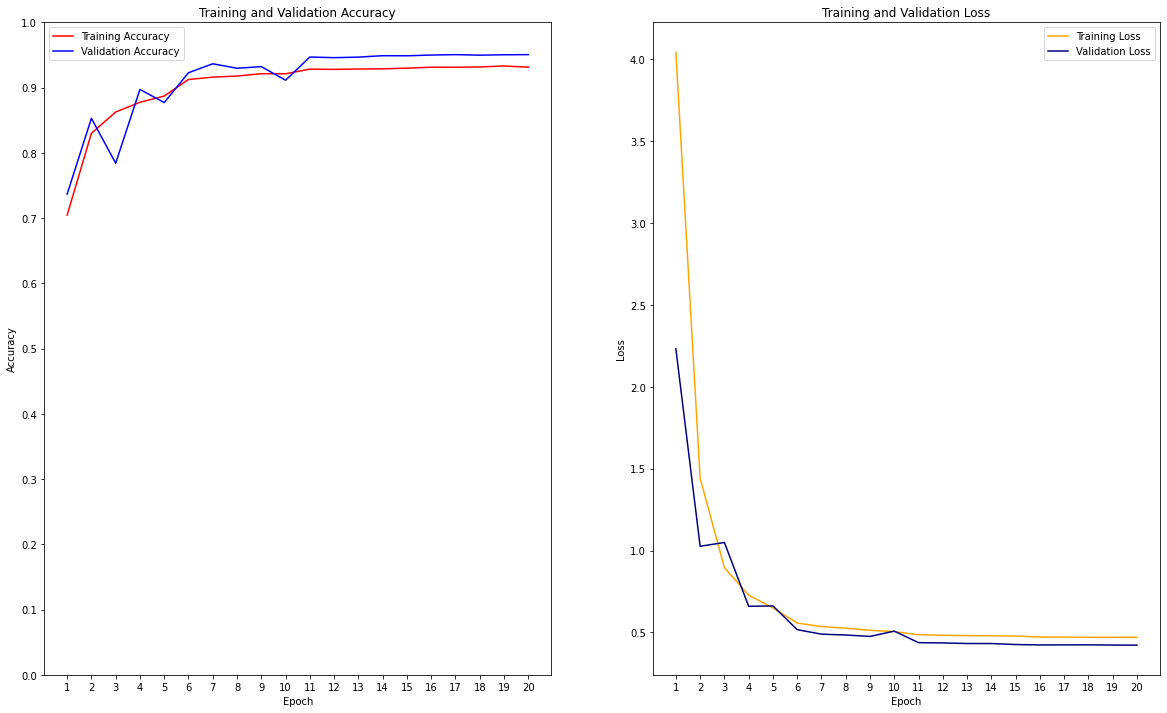

In [ ]:
# Plot Accuracy & Loss
plot_acc_and_loss(history)

### 2. Confusion Matrix

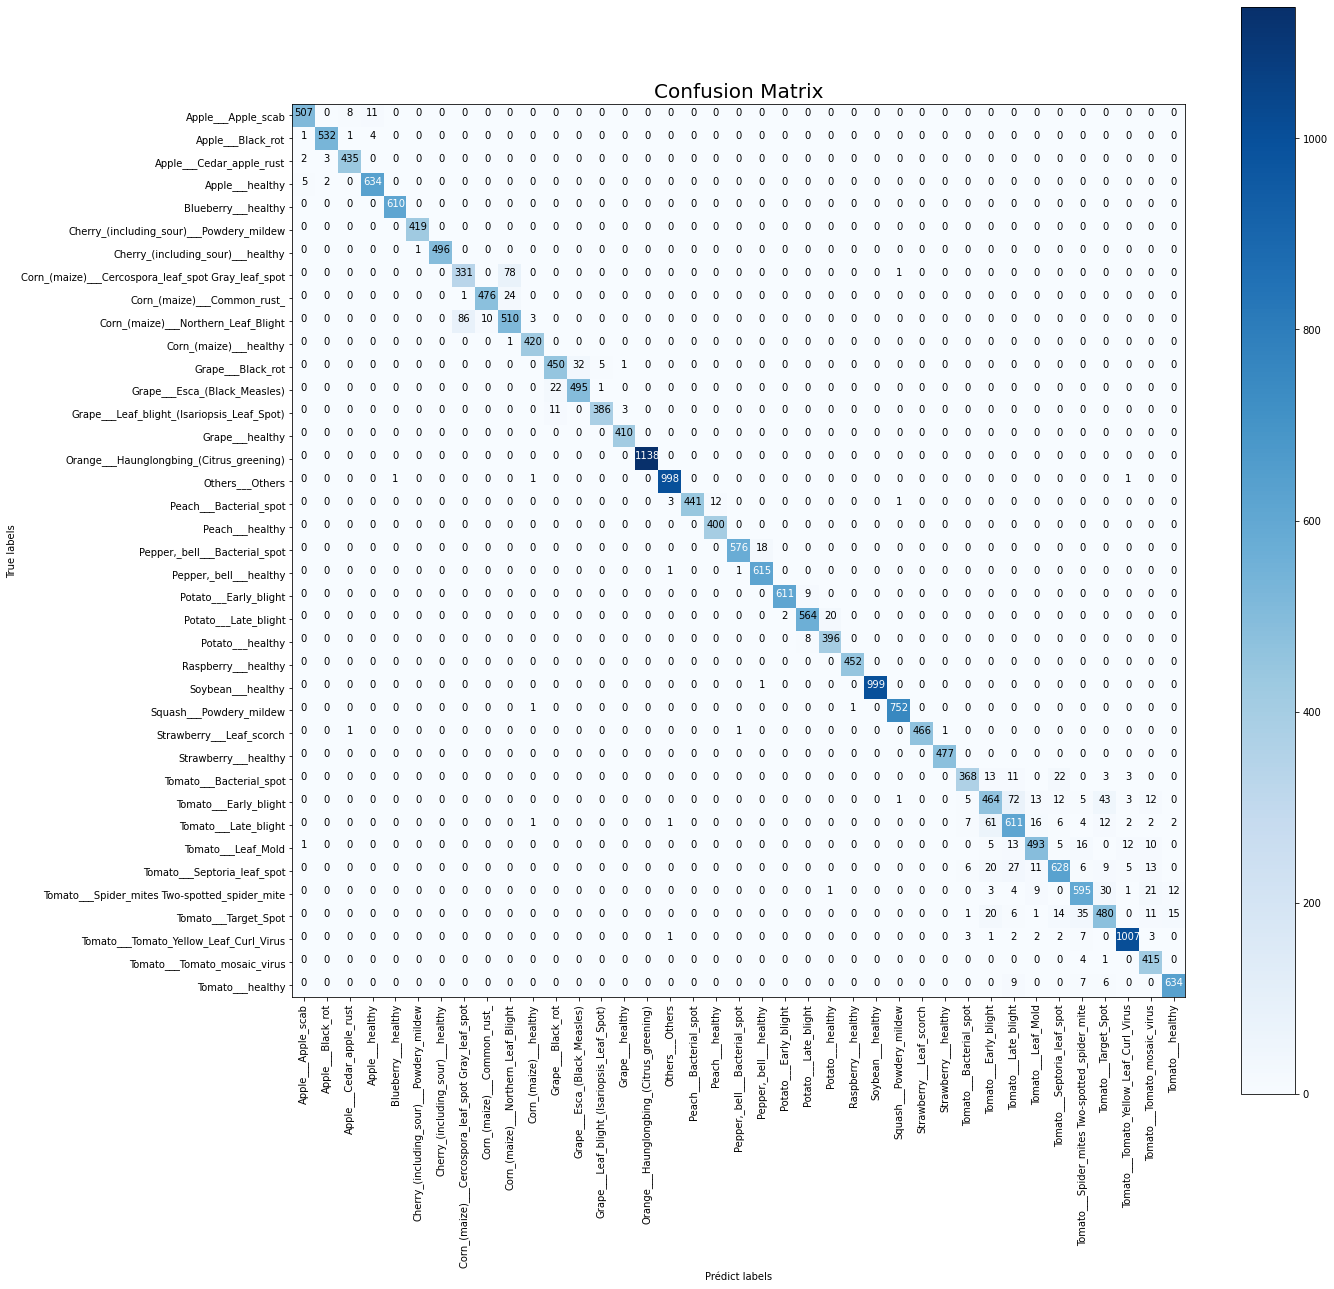

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(np.argmax(label))

    return img,lbl


# Get predictions
predictions_valid = model.predict(dataset_valid)
predictions_valid_int=np.argmax(predictions_valid,axis=1)
# Get Validation datset images and true labels
imgs_valid, labels_valid = unbatchify(dataset_valid)


# Confusion matrix
from sklearn import metrics
import itertools

def Confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()

Confusion_matrix(labels_valid, predictions_valid_int)

### 3. Predictions from Valid Dataset

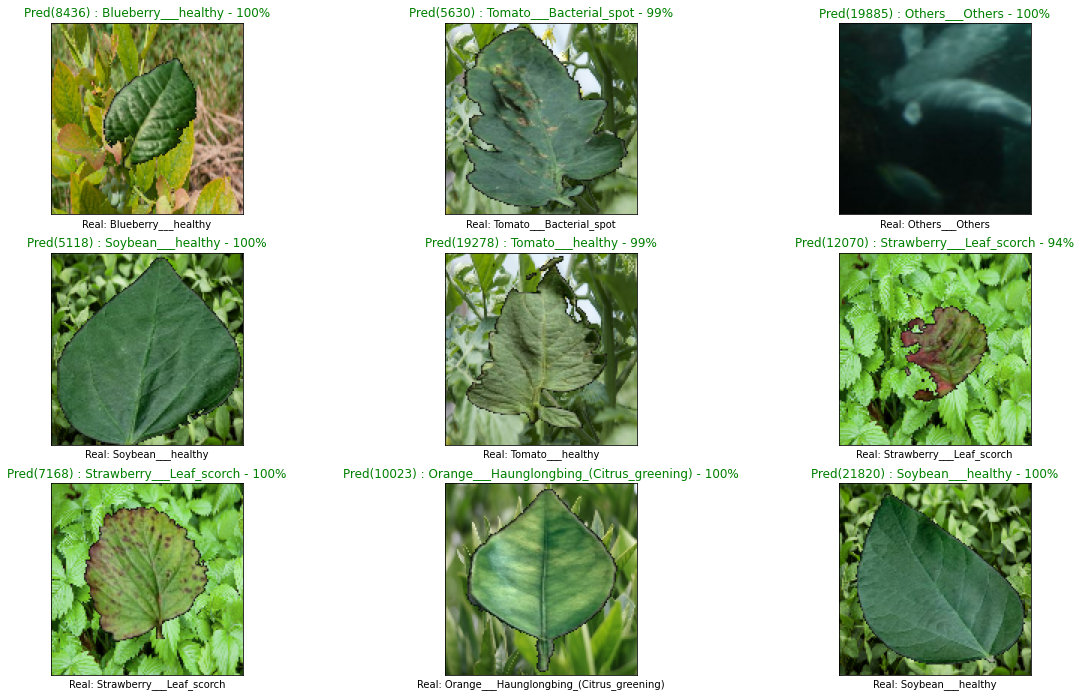

In [ ]:
# Show images and prediction rate
def show_img_and_prediction(imgs, labels,predictions, nb_img=9):

    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red'

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])

        if unique_plant_cat[np.argmax(predictions[i])] == unique_plant_cat[labels[i]]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, unique_plant_cat[np.argmax(predictions[i])], np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(unique_plant_cat[labels[i]]));

show_img_and_prediction(imgs_valid, labels_valid,predictions_valid)

#Evaluate model with Test dataset

##1. Accuracy for test dataset

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/30 - Models/saved_models/20210226-14171614349041-CNN_iteration_2_fix_backgrnd_acc-0.951.h5')

Loading saved model from: /content/drive/MyDrive/DataScientest/30 - Models/saved_models/20210226-14171614349041-CNN_iteration_2_fix_backgrnd_acc-0.951.h5...


In [ ]:

# Create Test Datset
df_test = create_info_df(TEST_PATH, True)
df_test['label_int'] = df_test['plant___category'].apply(lambda x: list_class.index(x))
dataset_test = create_dataset(df_test, True)

# Get Validation Loss and Accuracy
val_loss_test, val_acc_test = model.evaluate(dataset_test)
val_acc_test = round(val_acc_test, 3)
print('Accuracy for test DataSet:',val_acc_test)

Creation of the validation dataset...
48/48 [==============================] - 446s 9s/step - loss: 7.1078 - accuracy: 0.1051
Accuracy for test DataSet: 0.105


In [ ]:
imgs, labels = next(iter(dataset_test))

In [ ]:
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image)
        lbl.append(np.argmax(label))

    return img,lbl
imgt, labelt = unbatchify(dataset_test)

(16, 15)

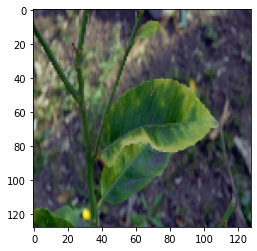

In [ ]:
plt.imshow(imgt[2])
predictions_test_int[2], labelt[2]
#predictions_test[1]


'Orange___Haunglongbing_(Citrus_greening)'

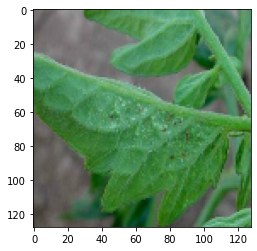

In [ ]:
imgs[1], labels[0]

plt.imshow(imgs[4])
list_class[np.argmax(labels[4])]

## 2. Confusion Matrix

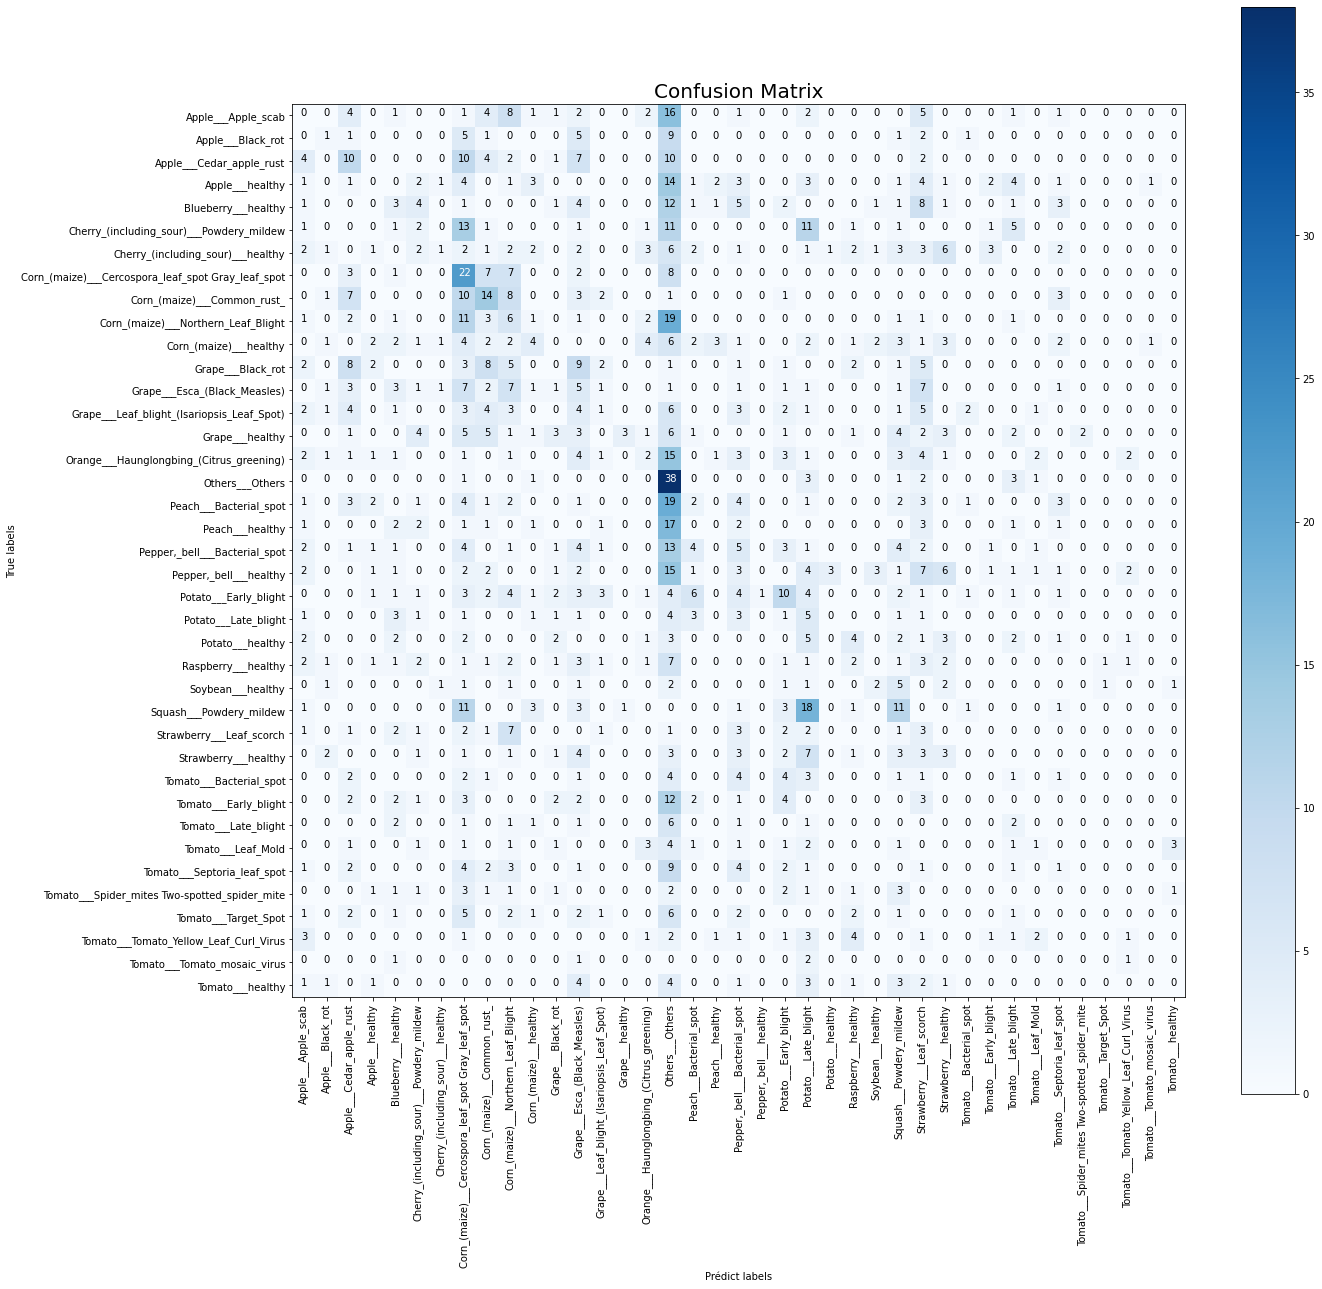

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image)
        lbl.append(np.argmax(label))

    return img,lbl


# Get predictions
predictions_test = model.predict(dataset_test)
predictions_test_int = np.argmax(predictions_test,axis=1)
# Get Test dataset images and true labels
imgs_test, labels_test = unbatchify(dataset_test)


# Confusion matrix
from sklearn import metrics
import itertools

def Confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()

Confusion_matrix(labels_test, predictions_test_int)